<span style="text-align: center">
<h1>Cloud-Masked NDVI timeseries & Zonal Stats</h2>
<h2>(based on Sentinel-2 COG)</h2>
</span>

This demo notebook shows how to generate cloud-masked NDVI timeseries by means of [openEO](https://openeo.org/about.html)-compliant back-end API.

The process is based on Copernicus Sentinel-2 high resolution optical imagery dataset [freely available](https://registry.opendata.aws/sentinel-2-l2a-cogs/) on AWS as Cloud Optimized GeoTIFF (COG). Images metadata are available through a [Spatio-Temporal Asset Catalog (STAC)](https://stacspec.org/) collection named [sentinel-s2-l2a-cogs](https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs).

<p style="text-align:center"><img src="https://openeo.org/images/openeo_logo.png" /></p>

### What is openEO project?

The task of the openEO project is to design, develop, and evaluate a standard API for interoperable cloud-based Earth Observation data processing and simplify user access to these services. The acronym contracts two concepts:

- **open**: used here in the context of open source software; open source software is available in source code form, and can be freely modified and redistributed; the openEO project will create open source software, reusable under a liberal open source license (Apache 2.0)
- **EO**: Earth observation


### Why openEO?

- Backends have to implement only the application programming interface (API) [specification](https://api.openeo.org/)
- Clients have several ready-to-use softwares to connect easely to back-ends as, for example, QGIS plugin or Python module


In [1]:
from notebook_utils import *

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

## Preliminary steps

1. **Configure directory in which the results will be downloaded**


In [3]:
local_directory = input("Insert the local directory where you want to download your results: ")

Insert the local directory where you want to download your results/home/vagrant/temp


2. **Connect to OpenEO back-end**  

   OpenEO API allows to choose between different authentication methods.  
   In our implementation, authentication with username and password (Basic) is required to generate a Bearer token necessary to grant the access to other openEO API endpoints.

In [4]:
openeo_url = 'http://localhost:8080/api/'
con = openeo.connect(openeo_url)

client_username = 'niva-user'
client_password = 'guest1234'
con = con.authenticate_basic(client_username,client_password)

## Input parameters

In the following section, we are going to set the parameters required by the processing.  
As in mostly all Earth Observation analysis, it is necessary to specify:
- An Area of Interest (AoI)
- A period of interest
- Product bands to be used

**Area: Load polygons of parcels in GeoJSON format**

In [5]:
with open("fields_collection.json", 'r') as f:
    input_geometry = json.load(f)

**Period of interest**

In [6]:
start_date = "2020-05-01T00:00:00Z"
end_date = "2020-06-30T23:59:59Z"

**Bands: Load Red and NIR used in NDVI**

The Normalized difference vegetation index (NDVI) is an indicator that can be used to analyze remote sensing images assessing how much the target being observed contains live green vegetation.

The formula is:
<p style="text-align: center"><img src="https://gisgeography.com/wp-content/uploads/2014/12/ndvi-formula-300x123.png" /></p>

where, in Sentinel-2:
- **B04** is the Red band
- **B08** is the Near Infra-Red (NIR) band

However, multispectral optical images are affected by clouds. In order to avoid unwanted effects in the analysis, data are "masked" using a specific raster (SCL) provided in the Level-2A product.  

In [7]:
data_bands = ["B04", "B08"]
cloud_mask = ["SCL"]

## Create the process graph

A process graph is a chain of specific process calls from the set of pre-defined and user-defined processes. It organizes and automates the execution of one or more processes that could alternatively be executed individually.  
In a process graph, input parameters can be scalars, arrays, objects, references to parameters or previous computations or other process graphs and they need to be always specified.  

Usually, the first step of the process graph creation is a `load_collection` process, which consists of loading a collection from the current back-end by its id and returns it as a processable **data cube**. The data that is added to the data cube can be restricted with the additional `spatial_extent`, `temporal_extent`, `bands` and `properties` as it will be shown in the following example.

### What are Datacubes?

Datacubes are multidimensional arrays with one or more spatial / temporal dimension(s). They are the way in which data is represented in OpenEO and provide an interface for spatiotemporal data as well as the operations you may want to execute on it. Datacubes can be easely represented as raster data but can hold vector data as well. 

**Load datacube**

The following datacube will contain `B04` and `B08` data on the parcels previously loaded referring to the specified period of interest.

In [8]:
sentinel2_data_cube = con.load_collection(
    "sentinel-s2-l2a-cogs",
    spatial_extent = input_geometry,
    temporal_extent = [
      start_date,
      end_date
    ],
    bands = data_bands
)

**Load cloud mask datacube**

The following datacube will contain cloud mask data on the parcels previously loaded referring to the specified period of interest.

In [9]:
sentinel2_mask_cube = con.load_collection(
    "sentinel-s2-l2a-cogs",
    spatial_extent = input_geometry,
        temporal_extent = [
          start_date,
          end_date
        ],
    bands=cloud_mask
)

**Concatenate processes**

The processes involved in the Cloud-Masked NDVI computation are:
- NDVI calculation
- Cloud Masking
- Save results in GeoTIFF format

In [10]:
sentinel2_data_cube = sentinel2_data_cube.process("ndvi", data = sentinel2_data_cube)

In [11]:
sentinel2_data_cube = sentinel2_data_cube.process("mask", data = sentinel2_data_cube, mask = sentinel2_mask_cube)

In [12]:
ndvi_data_cube = sentinel2_data_cube.process("save_result", data = sentinel2_data_cube, format="GTiff")

In [13]:
job_json = con._build_request_with_process_graph(process_graph=ndvi_data_cube.graph)
# print(json.dumps(job_json, indent=2))

## Submit processing request to openEO backend

In order to do that, first we have to create a processing request to openEO backend.

In [14]:
job = con.create_job(ndvi_data_cube)
print(f"Job ID is: {job.job_id}")

Job ID is: 6c2846d0-3450-4297-a814-e9bab38bb765


Now we are ready to start it and wait for job completion

In [15]:
job.start_and_wait()

0:00:00 Job '6c2846d0-3450-4297-a814-e9bab38bb765': send 'start'
0:00:00 Job '6c2846d0-3450-4297-a814-e9bab38bb765': queued (progress N/A)
0:00:05 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:00:11 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:00:19 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:00:29 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:00:41 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:00:56 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:01:15 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:01:39 Job '6c2846d0-3450-4297-a814-e9bab38bb765': running (progress N/A)
0:02:09 Job '6c2846d0-3450-4297-a814-e9bab38bb765': finished (progress N/A)


<RESTJob job_id='6c2846d0-3450-4297-a814-e9bab38bb765'>

## Download and show results

In [16]:
results = job.get_results()
results

<JobResults for job '6c2846d0-3450-4297-a814-e9bab38bb765'>

In [17]:
output_directory = os.path.join(local_directory, job.job_id)
os.makedirs(output_directory, exist_ok=True)

all_ndvi = results.download_files(output_directory)

⚠️ Warning ⚠️  

Empty plots are due to high cloud coverage in those dates 

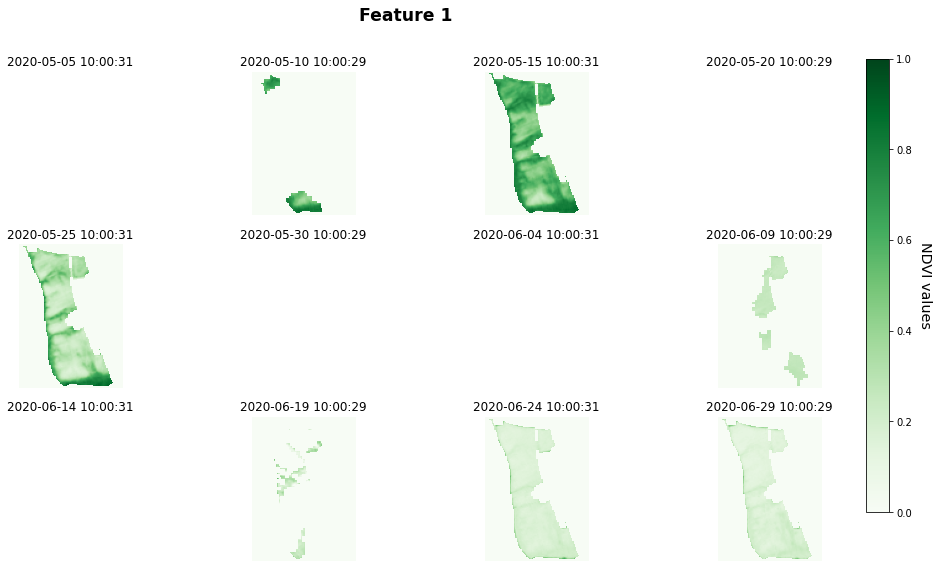

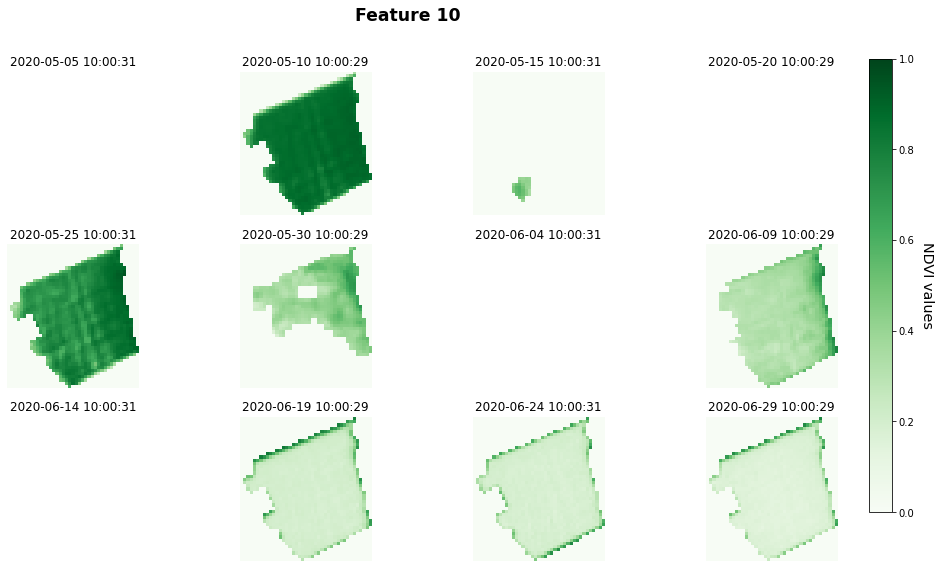

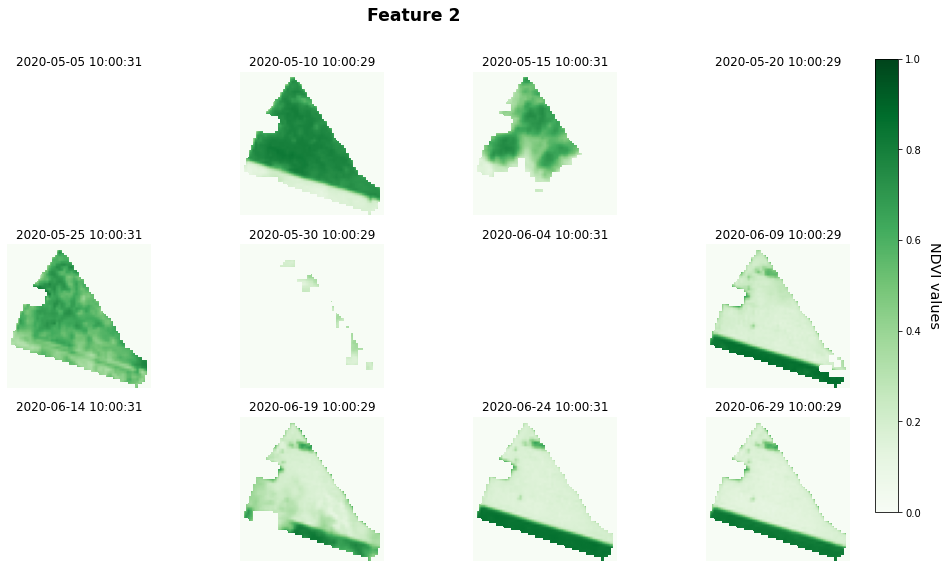

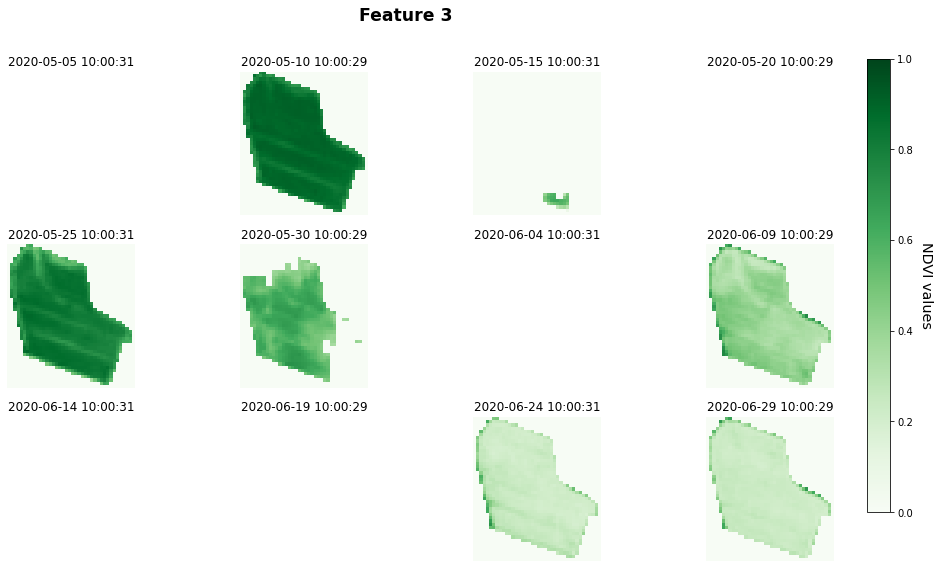

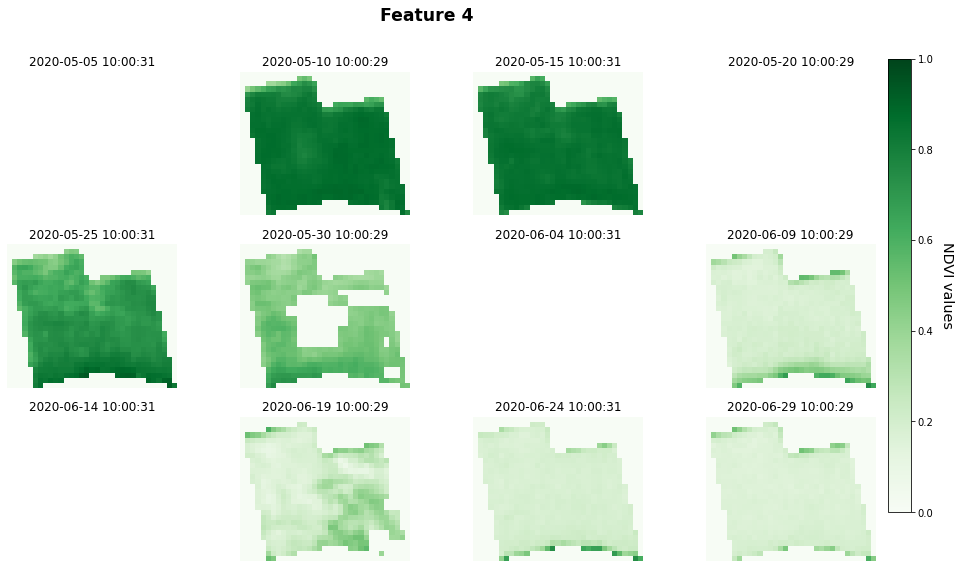

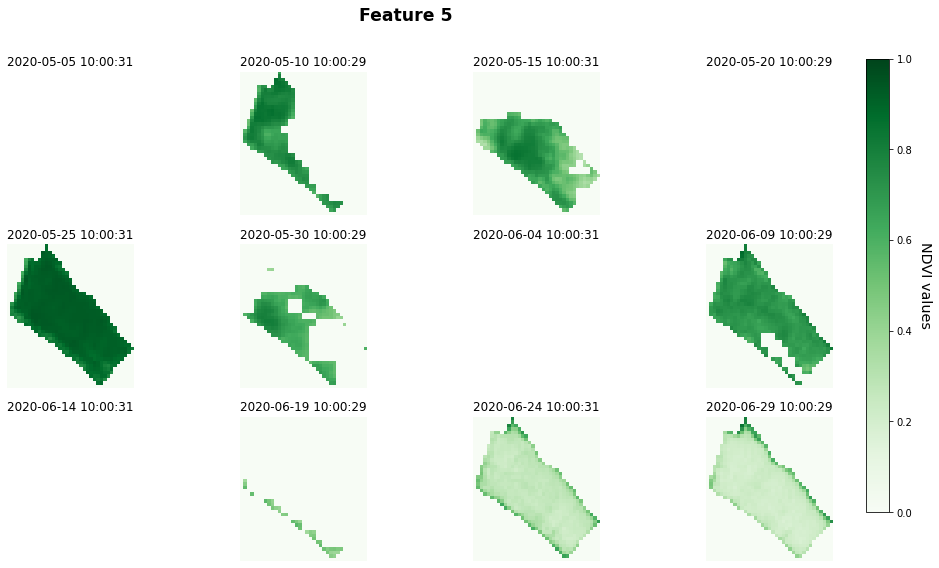

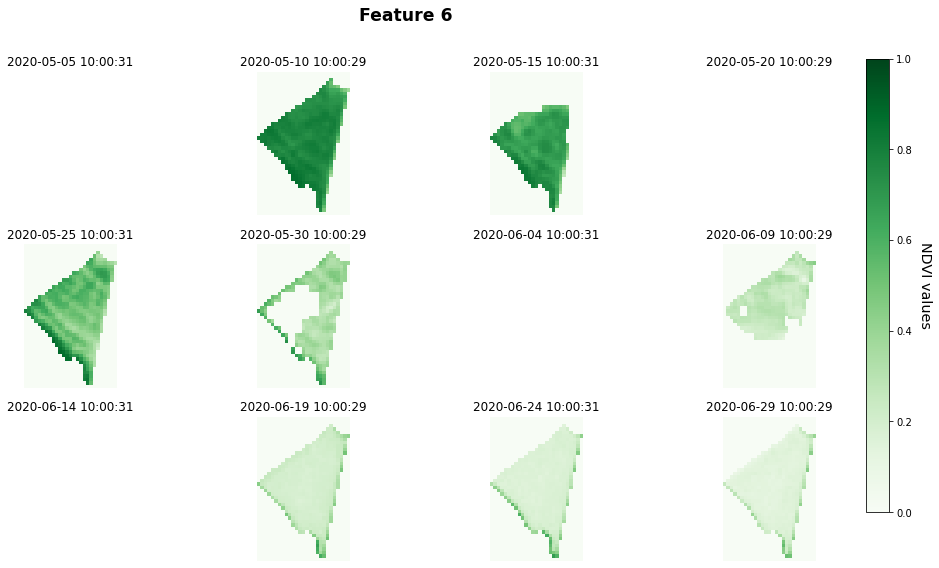

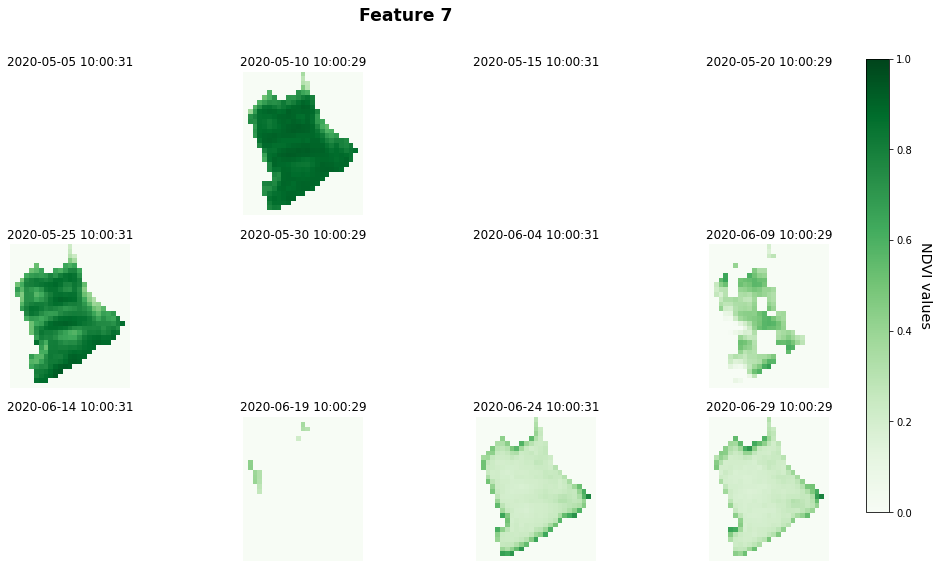

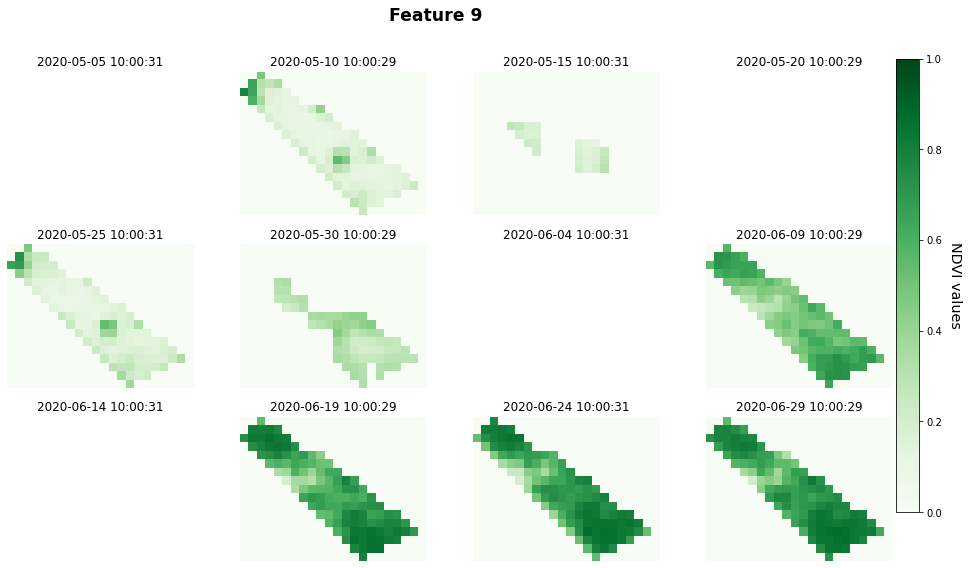

In [18]:
plot_ndvi_timeseries(all_ndvi)

# Zonal Statistics

Backend offers also the possibility to compute the zonal statistics over the parcels of interest. Computed statistics are:
- count_value
- mean_value
- variance_value
- min_value
- first_quartile_value
- median_value
- third_quartile_value
- max_value
- skewness_value
- kurtosis_value

So, it can be done just adding the `aggregate_spatial` process to process graph and submit this new job.

In [19]:
zonal_stats_data_cube = sentinel2_data_cube.process("aggregate_spatial", data = sentinel2_data_cube)

In [20]:
zonal_stats_data_cube = zonal_stats_data_cube.process("save_result", data = zonal_stats_data_cube)

In [21]:
job = con.create_job(zonal_stats_data_cube)
print(f"Job ID is: {job.job_id}")

Job ID is: a94167f0-7a65-4797-98f1-c081d5eb1411


In [22]:
job.start_and_wait()

0:00:00 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': send 'start'
0:00:00 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': queued (progress N/A)
0:00:05 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:00:11 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:00:19 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:00:29 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:00:41 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:00:56 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:01:15 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:01:39 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:02:09 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': running (progress N/A)
0:02:46 Job 'a94167f0-7a65-4797-98f1-c081d5eb1411': finished (progress N/A)


<RESTJob job_id='a94167f0-7a65-4797-98f1-c081d5eb1411'>

In [23]:
results = job.get_results()
results

<JobResults for job 'a94167f0-7a65-4797-98f1-c081d5eb1411'>

In [24]:
output_directory = os.path.join(local_directory, job.job_id)
os.makedirs(output_directory, exist_ok=True)

all_zonal_stats = results.download_files(output_directory)

In [25]:
output_geojsons = [output for output in all_zonal_stats if os.path.basename(output).endswith(".json")]
get_feature_stats(output_geojsons[0], "1")

count_value  mean_value  variance_value  min_value  first_quartile_value  \
3          542      0.6341          0.0189     0.3475                0.5294   
0         3863      0.5859          0.0192     0.0651                0.4795   
1         3865      0.3732          0.0291     0.0442                0.2481   
4         1156      0.2628          0.0004     0.1680                0.2509   
5          680      0.2194          0.0112    -0.1340                0.1670   
2         3865      0.1878          0.0037     0.1199                0.1564   
6         3865      0.1758          0.0029     0.0734                0.1409   

   median_value  third_quartile_value  max_value  skewness_value  \
3        0.6410                0.7612     0.8600         -0.2038   
0        0.5956                0.6888     0.8640         -0.2622   
1        0.3226                0.4424     0.9258          1.2229   
4        0.2615                0.2729     0.4347          1.5691   
5        0.2301                0.2890     0.5556         -0.5699   
2        0.1702                0.1968     0.7163          3.5197   
6        0.1623                0.1961     0.6239          2.4978   

   kurtosis_value              datetime  \
3         -1.0890  2020-05-10T10:08:37Z   
0         -0.4340  2020-05-15T10:08:44Z   
1          0.8014  2020-05-25T10:08:45Z   
4         10.1414  2020-06-09T10:08:41Z   
5          0.7187  2020-06-19T10:08:42Z   
2         16.2033  2020-06-24T10:08:45Z   
6          9.3587  2020-06-29T10:08:41Z   

                                          product_id feature_id  
3  S2B_MSIL2A_20200510T100029_N0214_R122_T33TUJ_2...          1  
0  S2A_MSIL2A_20200515T100031_N0214_R122_T33TUJ_2...          1  
1  S2A_MSIL2A_20200525T100031_N0214_R122_T33TUJ_2...          1  
4  S2B_MSIL2A_20200609T100029_N0214_R122_T33TUJ_2...          1  
5  S2B_MSIL2A_20200619T100029_N0214_R122_T33TUJ_2...          1  
2  S2A_MSIL2A_20200624T100031_N0214_R122_T33TUJ_2...          1  
6  S2B_MSIL2A_20200629T100029_N0214_R122_T33TUJ_2...          1

## Select the output file and generate the CSV input for the UC1b (output.json) 

In [26]:
output_directory_json = os.path.join(local_directory, job.job_id)
output_directory_json

'/home/vagrant/temp/a94167f0-7a65-4797-98f1-c081d5eb1411'

In [27]:
with open(os.path.join(output_directory_json,'saveresult1/output.json')) as f:
    zonal_stats = json.load(f)

In [29]:
o = write_csv_from_geojson_dict(zonal_stats, 'out_UC1b', '/home/vagrant/temp/')